In [1]:
import os,sys
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import glob as glob
import numpy as np
import warnings
from scipy.stats import ttest_ind,f_oneway
import lightgbm as lgb

from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score
from sklearn.pipeline import Pipeline, FeatureUnion

from plot_functions import plot_count, plot_box, plot_box_category, plot_regplot, barplot_count_multicat, \
barplot_pct_multicat, plot_confusion_matrix

%reload_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

warnings.filterwarnings(action='once')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
data_path = os.path.join(os.getcwd(),"Animal State Prediction - dataset")
os.chdir(data_path)
print(data_path)

E:\Projects\ZS_Hackerrank_Feb2020\Animal State Prediction - dataset


In [30]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
display(train_df.head())
display(test_df.head())
# train_df["intake_datetime"] = pd.to_datetime("intake_datetime")
# train_df["date_of_birth"] = pd.to_datetime("date_of_birth")
# train_df["outcome_datetime"] = pd.to_datetime("outcome_datetime")

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,outcome_type
0,A006100,2007,7,10 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,10 years,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,Return to Owner
1,A006100,2007,7,7 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722,7 years,2007-07-09 00:00:00,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,2014,2014-12,Saturday,16,2.0,Return to Owner
2,A006100,2007,7,6 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889,6 years,2007-07-09 00:00:00,Neutered Male,2190,6.0,"(5.0, 7.5]",NaN,3,2014,2014-03,Saturday,17,3.0,Return to Owner
3,A047759,2004,4,10 years,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,10 years,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,Missing
4,A134067,1997,10,16 years,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,1,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,16 years,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,Return to Owner


,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number
0,A723133,2013,3,3 years,Cat,Domestic Shorthair Mix,Brown Tabby,Nursing,Stray,Intact Female,1,1095,3.000000,"(2.5, 5.0]",27-03-2016 11:31,3,2016,2016-03,Sunday,11,1,5 days 04:48:00.000000000,5.200000,3 years,27-03-2013 00:00,Spayed Female,1095,3.000000,"(2.5, 5.0]",01-04-2016 16:19,4,2016,2016-04,Friday,16,1
1,A723134,2016,2,4 weeks,Cat,Domestic Shorthair Mix,Brown Tabby,Nursing,Stray,Intact Female,1,28,0.076712,"(-0.025, 2.5]",27-03-2016 11:31,3,2016,2016-03,Sunday,11,1,34 days 06:11:00.000000000,34.257639,2 months,27-02-2016 00:00,Spayed Female,60,0.164384,"(-0.025, 2.5]",30-04-2016 17:42,4,2016,2016-04,Saturday,17,1
2,A723135,2016,2,4 weeks,Cat,Domestic Shorthair Mix,Brown Tabby,Nursing,Stray,Intact Male,1,28,0.076712,"(-0.025, 2.5]",27-03-2016 11:31,3,2016,2016-03,Sunday,11,1,32 days 12:29:00.000000000,32.520139,2 months,27-02-2016 00:00,Neutered Male,60,0.164384,"(-0.025, 2.5]",29-04-2016 00:00,4,2016,2016-04,Friday,0,1
3,A723136,2016,2,4 weeks,Cat,Domestic Shorthair Mix,Brown Tabby,Nursing,Stray,Intact Female,1,28,0.076712,"(-0.025, 2.5]",27-03-2016 11:31,3,2016,2016-03,Sunday,11,1,31 days 02:16:00.000000000,31.094444,1 month,27-02-2016 00:00,Intact Female,30,0.082192,"(-0.025, 2.5]",27-04-2016 13:47,4,2016,2016-04,Wednesday,13,1
4,A723137,2016,2,4 weeks,Cat,Domestic Shorthair Mix,Blue Tabby,Nursing,Stray,Intact Female,1,28,0.076712,"(-0.025, 2.5]",27-03-2016 11:31,3,2016,2016-03,Sunday,11,1,37 days 00:11:00.000000000,37.007639,2 months,27-02-2016 00:00,Intact Female,60,0.164384,"(-0.025, 2.5]",03-05-2016 11:42,5,2016,2016-05,Tuesday,11,1


In [31]:
dup_df = train_df[train_df.duplicated(subset=["animal_id_outcome"],keep='first')]

In [32]:
dup_df.outcome_type.value_counts() / train_df.outcome_type.value_counts()

Adoption           0.136423
Died               0.076352
Disposal                NaN
Euthanasia         0.002172
Missing            0.092728
Relocate           0.090944
Return to Owner    0.221856
Rto-Adopt          0.093469
Transfer           0.026100
Name: outcome_type, dtype: float64

In [33]:
f_train_df = train_df[train_df.duplicated(subset=["animal_id_outcome"],keep='first')==False]
f_train_df.outcome_type.value_counts() / train_df.outcome_type.value_counts()

Adoption           0.863577
Transfer           0.973900
Return to Owner    0.778144
Euthanasia         0.997828
Died               0.923648
Missing            0.907272
Relocate           0.909056
Rto-Adopt          0.906531
Disposal           1.000000
Name: outcome_type, dtype: float64

In [34]:
train_df = f_train_df
f_train_df.outcome_type.value_counts() / train_df.outcome_type.value_counts()

Adoption           1.0
Transfer           1.0
Return to Owner    1.0
Euthanasia         1.0
Died               1.0
Missing            1.0
Relocate           1.0
Rto-Adopt          1.0
Disposal           1.0
Name: outcome_type, dtype: float64

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42679 entries, 0 to 47802
Data columns (total 37 columns):
animal_id_outcome             42679 non-null object
dob_year                      42679 non-null int64
dob_month                     42679 non-null int64
age_upon_intake               42679 non-null object
animal_type                   42679 non-null object
breed                         42679 non-null object
color                         42679 non-null object
intake_condition              42679 non-null object
intake_type                   42679 non-null object
sex_upon_intake               42678 non-null object
count                         42679 non-null int64
age_upon_intake_(days)        42679 non-null int64
age_upon_intake_(years)       42679 non-null float64
age_upon_intake_age_group     42679 non-null object
intake_datetime               42679 non-null object
intake_month                  42679 non-null int64
intake_year                   42679 non-null int64
intake_month

In [36]:
train_df['sex'] = np.where(train_df['sex_upon_outcome'].str.contains('Male'), 'Male', 'Female')
train_df['Spay/Neuter'] = np.where(train_df['sex_upon_outcome'].str.contains('Intact'), 'No', 'Yes')

In [37]:
train_df.head()

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,outcome_type,sex,Spay/Neuter
0,A006100,2007,7,10 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,10 years,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,Return to Owner,Male,Yes
3,A047759,2004,4,10 years,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,10 years,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,Missing,Male,Yes
4,A134067,1997,10,16 years,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,1,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,16 years,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,Return to Owner,Male,Yes
5,A141142,1998,6,15 years,Dog,Labrador Retriever/Pit Bull,Black/White,Aged,Stray,Spayed Female,1,5475,15.0,"(12.5, 15.0]",2013-11-16 14:46:00,11,2013,2013-11,Saturday,14,1.0,0 days 20:54:00.000000000,0.870833,15 years,1998-06-01 00:00:00,Spayed Female,5475,15.0,"(12.5, 15.0]",2013-11-17 11:40:00,11,2013,2013-11,Sunday,11,1.0,Return to Owner,Female,Yes
6,A163459,1999,10,15 years,Dog,Miniature Schnauzer Mix,Black/Gray,Normal,Stray,Intact Female,1,5475,15.0,"(12.5, 15.0]",2014-11-14 15:11:00,11,2014,2014-11,Friday,15,1.0,0 days 04:17:00.000000000,0.178472,15 years,1999-10-19 00:00:00,Intact Female,5475,15.0,"(12.5, 15.0]",2014-11-14 19:28:00,11,2014,2014-11,Friday,19,1.0,Return to Owner,Female,No


In [38]:
train_df.shape

(42679, 39)

In [39]:
train_df['breed'].value_counts()

Domestic Shorthair Mix                    12752
Pit Bull Mix                               2988
Chihuahua Shorthair Mix                    2676
Labrador Retriever Mix                     2083
Domestic Medium Hair Mix                   1218
                                          ...  
Harrier/Pointer                               1
Schnauzer Giant/Labrador Retriever            1
German Shepherd/Australian Kelpie             1
Catahoula/Irish Wolfhound                     1
Border Collie/English Springer Spaniel        1
Name: breed, Length: 1847, dtype: int64

In [40]:
train_df['breed'] = train_df['breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

In [10]:
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

In [41]:
train_df = pd.concat([train_df, 
                     train_df['breed'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

train_df['cfa_breed'] = np.where((train_df['breed1'].str.contains(cfa_breeds)) | 
                                (train_df['breed2'].str.contains(cfa_breeds)), 
                                True, False)

train_df['domestic_breed'] = np.where((train_df['breed1'].str.contains(cfa_breeds) == False) | 
                                     (train_df['breed2'].str.contains(cfa_breeds) == False), 
                                     True, False)


NameError: name 'cfa_breeds' is not defined

In [42]:
train_df['color'].value_counts()

Black/White         4396
Black               3481
Brown Tabby         2402
Brown               1921
White               1486
                    ... 
Blue/Orange            1
Blue Tabby/Cream       1
Yellow/Brown           1
Fawn/Tricolor          1
Yellow/Tan             1
Name: color, Length: 443, dtype: int64

In [43]:
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

In [44]:
coat_reg = '(' + '|'.join(coat_patterns) + ')'

In [45]:
train_df['color'] = train_df['color'].str.lower()

train_df['coat_pattern'] = train_df['color'].str.extract(coat_reg, expand=False)

train_df['color'] = train_df['color'].str.replace(coat_reg, '').str.strip()

In [46]:
train_df = pd.concat([train_df, 
                     train_df['color'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

train_df['color1'] = np.where(train_df['color1'] == '', 'Breed Specific', train_df['color1'])

train_df['coat'] = np.where(train_df['color1'] == 'Breed Specific', train_df['coat_pattern'], train_df['color1'])

In [47]:
train_df

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,outcome_type,sex,Spay/Neuter,breed1,breed2,2,coat_pattern,color1,color2,coat
0,A006100,2007,7,10 years,Dog,spinone italiano,yellow/white,Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,10 years,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,Return to Owner,Male,Yes,spinone italiano,None,None,NaN,yellow,white,yellow
3,A047759,2004,4,10 years,Dog,dachshund,,Normal,Owner Surrender,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,10 years,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,Missing,Male,Yes,dachshund,None,None,tricolor,Breed Specific,None,tricolor
4,A134067,1997,10,16 years,Dog,shetland sheepdog,brown/white,Injured,Public Assist,Neutered Male,1,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,16 years,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,Return to Owner,Male,Yes,shetland sheepdog,None,None,NaN,brown,white,brown
5,A141142,1998,6,15 years,Dog,labrador retriever/pit bull,black/white,Aged,Stray,Spayed Female,1,5475,15.0,"(12.5, 15.0]",2013-11-16 14:46:00,11,2013,2013-11,Saturday,14,1.0,0 days 20:54:00.000000000,0.870833,15 years,1998-06-01 00:00:00,Spayed Female,5475,15.0,"(12.5, 15.0]",2013-11-17 11:40:00,11,2013,2013-11,Sunday,11,1.0,Return to Owner,Female,Yes,labrador retriever,pit bull,None,NaN,black,white,black
6,A163459,1999,10,15 years,Dog,miniature schnauzer,black/gray,Normal,Stray,Intact Female,1,5475,15.0,"(12.5, 15.0]",2014-11-14 15:11:00,11,2014,2014-11,Friday,15,1.0,0 days 04:17:00.000000000,0.178472,15 years,1999-10-19 00:00:00,Intact Female,5475,15.0,"(12.5, 15.0]",2014-11-14 19:28:00,11,2014,2014-11,Friday,19,1.0,Return to Owner,Female,No,miniature schnauzer,None,None,NaN,black,gray,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47798,A723128,2007,9,8 years,Cat,domestic longhair,black/white,Normal,Stray,Neutered Male,1,2920,8.0,"(7.5, 10.0]",2016-03-27 11:24:00,3,2016,2016-03,Sunday,11,1.0,21 days 12:36:00.000000000,21.525000,8 years,2007-09-27 00:00:00,Neutered Male,2920,8.0,"(7.5, 10.0]",2016-04-18 00:00:00,4,2016,2016-04,Monday,0,1.0,Rto-Adopt,Male,Yes,domestic longhair,None,None,NaN,black,white,black
47799,A723129,2015,3,1 year,Dog,cairn terrier,gray/white,Normal,Owner Surrender,Intact Male,1,365,1.0,"(-0.025, 2.5]",2016-03-27 11:44:00,3,2016,2016-03,Sunday,11,1.0,2 days 07:22:00.000000000,2.306944,1 year,2015-03-27 00:00:00,Neutered Male,365,1.0,"(-0.025, 2.5]",NaN,3,2016,2016-03,Tuesday,19,1.0,Adoption,Male,Yes,cairn terrier,None,None,NaN,gray,white,gray
47800,A723130,2005,3,11 years,Dog,shetland sheepdog,brown/tan,Normal,Stray,Spayed Female,1,4015,11.0,"(10.0, 12.5]",2016-03-27 11:44:00,3,2016,2016-03,Sunday,11,1.0,0 days 05:23:00.000000000,0.224306,11 years,2005-03-27 00:00:00,Spayed Female,4015,11.0,"(10.0, 12.5]",2016-03-27 17:07:00,3,2016,2016-03,Sunday,17,1.0,Return to Owner,Female,Yes,shetland sheepdog,None,None,NaN,brown,tan,brown
47801,A723131,2011,3,5 years,Dog,boxer/cata

In [8]:
x = train_df.filter(items=['sex_upon_outcome', 'breed', 'color', 'coat_pattern', 
                               'domestic_breed', 'dob_month', 'age_group', 'outcome_month', 
                               'outcome_weekday', 'outcome_hour'])

In [9]:
for col in x:
    x[col] = x[col].astype('category')
    
y = train_df['outcome_type'].astype('category')

In [10]:
xd = pd.get_dummies(x)

In [40]:
xnames = xd.columns
xarr = np.array(xd)

In [43]:
yarr, ynames = pd.factorize(train_df['outcome_type'])

In [46]:
x_train, x_test, y_train, y_test = train_test_split(xarr, yarr, 
                                                    test_size=0.3, random_state=1)

In [49]:
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [58]:
x_train.shape

(33462, 2078)

In [50]:
rf_classifier = RandomForestClassifier(n_estimators=250, criterion='gini', 
                                       class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

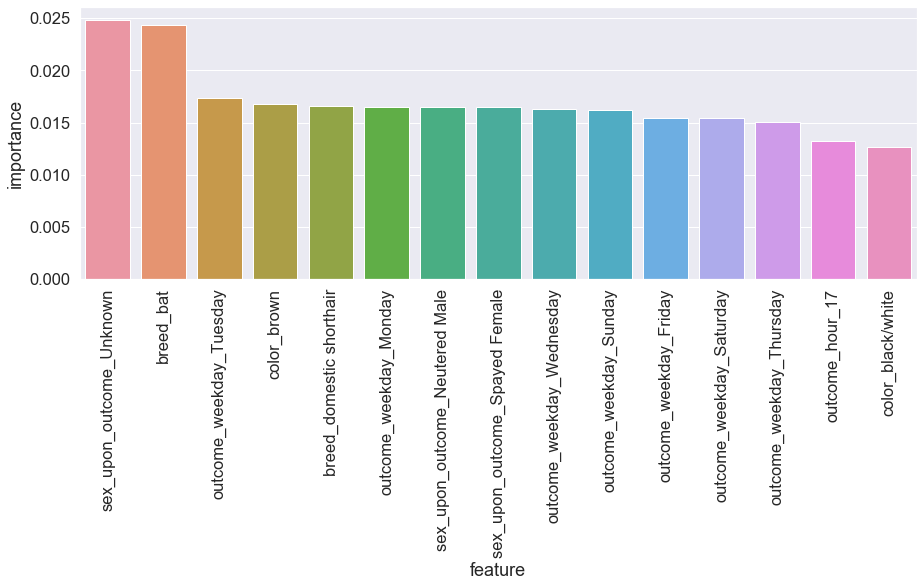

In [51]:
feature_importances = rf_classifier.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': xnames}, 
                           index=xnames).sort_values(by='importance', ascending=False)

plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

In [52]:
pca = PCA()
pca.fit(x_train_scaled)
print(len(pca.components_))

2078


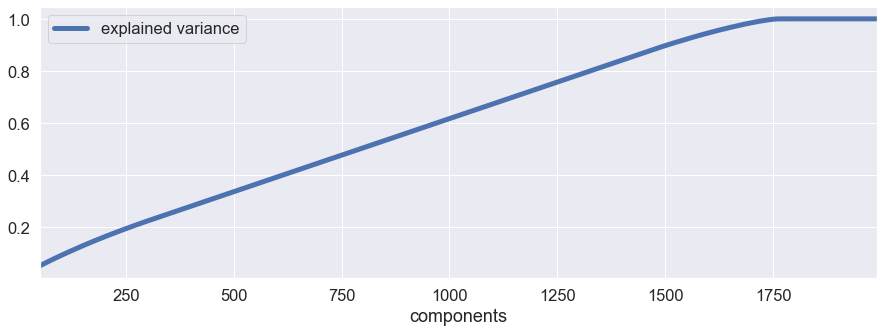

In [54]:
comps = np.arange(50, 2000, 10)
exp_var = []

for comp in comps:
    exp_var.append(sum(pca.explained_variance_ratio_[0:comp]))
    
pca_exp_var = pd.concat([pd.Series(comps, name='components'), 
                         pd.Series(exp_var, name='explained variance')], axis=1)

pca_exp_var.set_index('components', inplace=True)

pca_exp_var.plot(kind='line', linewidth=5, figsize=(15, 5))

In [56]:
feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('rf', RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                  class_weight='balanced_subsample', bootstrap=True, 
                                  oob_score=True))
])

In [57]:
prediction_model.fit(x_train_scaled, y_train)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  17   26   32   38   39   58   59   60   69   74   77   80   84   91
   92   93  100  108  109  113  131  134  137  146  157  167  170  190
  195  204  205  208  211  214  225  231  258  262  270  274  280  283
  285  290  296  306  308  312  318  323  329  332  338  340  347  353
  363  365  371  391  397  401  419  423  425  428  434  437  456  459
  468  473  484  485  489  495  498  499  505  506  512  526  534  535
  538  542  543  560  562  574  581  586  587  589  604  620  627  634
  638  641  647  648  651  656  669  672  683  688  699  704  707  714
  719  726  730  741  744  746  764  778  783  791  805  806  814  815
  817  819  829  851  872  877  878  891  905  907  908  916  923  931
  941  945  949  960  964  974  975  977  980  983  984  985 1011 1054
 1059 1063 1064 1070 1079 1080 1087 1098 1106 1124 1127 1128 1133 1143
 1149 1152 1155 1158

KeyboardInterrupt: 

In [ ]:
cv = StratifiedKFold(5)
cv_score = cross_val_score(prediction_model, x_train_scaled, y_train, cv=cv, scoring='accuracy')
cv_predict_score = cross_val_predict(prediction_model, x_train_scaled, y_train, cv=cv)

In [ ]:
print(cv_score)
print(np.mean(cv_score))

print(accuracy_score(y_train, cv_predict_score))

In [ ]:
train_df["breed_simple"] = train_df.breed.apply(lambda x: x.split("/")[0])
train_df["breed_simple"] = train_df.breed_simple.apply(lambda x: x.replace(" Mix",""))
train_df["color_simple"] = train_df.color.apply(lambda x: x.split("/")[0])

In [18]:
# COLS_DROP = ["dob_year","dob_month","age_upon_intake","age_upon_intake_(years)","age_upon_intake_age_group",\
#              "intake_datetime","intake_month","intake_year","intake_monthyear","intake_weekday","intake_hour","time_in_shelter",\
#              "age_upon_outcome","date_of_birth","age_upon_outcome_(years)","age_upon_outcome_age_group","outcome_datetime",\
#              "outcome_month","outcome_year","outcome_monthyear","outcome_weekday","outcome_hour","outcome_number"
#             ]

COLS_DROP = ["outcome_datetime"]
train_df.drop(COLS_DROP,axis=1,inplace=True)
train_df.dropna(how="any",inplace=True)
train_df.shape

(1, 47)

In [48]:
train_df.columns

Index([         'animal_id_outcome',                   'dob_year',
                        'dob_month',            'age_upon_intake',
                      'animal_type',                      'breed',
                            'color',           'intake_condition',
                      'intake_type',            'sex_upon_intake',
                            'count',     'age_upon_intake_(days)',
          'age_upon_intake_(years)',  'age_upon_intake_age_group',
                  'intake_datetime',               'intake_month',
                      'intake_year',           'intake_monthyear',
                   'intake_weekday',                'intake_hour',
                    'intake_number',            'time_in_shelter',
             'time_in_shelter_days',           'age_upon_outcome',
                    'date_of_birth',           'sex_upon_outcome',
          'age_upon_outcome_(days)',   'age_upon_outcome_(years)',
       'age_upon_outcome_age_group',           'outcome_dateti

## Modelling

### FINAL FEATURES LIST

In [50]:
# NUM_COLS = [
#     "dob_year","dob_month","count","age_upon_intake_(days)","age_upon_intake_(years)","intake_month","intake_year",\
#     "intake_hour","intake_number","time_in_shelter_days","age_upon_outcome_(days)","age_upon_outcome_(years)", \
#             "outcome_month","outcome_year","outcome_hour","outcome_number"
# ]

# CAT_COLS = [
#     "age_upon_intake","animal_type","intake_condition","intake_type","sex_upon_intake","age_upon_intake_age_group", \
#     "intake_monthyear","intake_weekday","age_upon_outcome","sex_upon_outcome","outcome_monthyear","outcome_weekday"
# ]

NUM_COLS = [
     'count','age_upon_intake_(days)', 'intake_number', 'time_in_shelter_days','age_upon_outcome_(days)',
"outcome_month","outcome_year","outcome_hour","outcome_number"
 ]

CAT_COLS = [
    'animal_type','intake_condition', 'intake_type', 'sex_upon_intake','sex_upon_outcome',"outcome_monthyear",\
    "outcome_weekday",'sex','Spay/Neuter','breed1','breed2','coat_pattern','color1','color2', 'coat'
]

RESPONSE = ["outcome_type"]

numerical_df = train_df[NUM_COLS]
categorical_df = pd.get_dummies(train_df[CAT_COLS])
response_df = train_df[RESPONSE]

for col in categorical_df.columns:
    if "]" in str(col) or "[" in str(col):
        new_name = str(col).replace("]",")").replace("[","(")
        categorical_df.rename({str(col):new_name},inplace=True,axis=1)
        print(f"Renamed from {col} ---> {new_name}")
        
all_df = pd.concat([numerical_df,categorical_df,response_df],axis=1)
print(f"Number of OHE features added: {all_df.shape[1]-len(NUM_COLS)-len(CAT_COLS)-1}")

Number of OHE features added: 696


### RANDOM OVERSAMPLING WITH RANDOM FOREST MODEL

In [55]:
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

X = all_df.drop(RESPONSE,axis=1)
y = all_df[RESPONSE]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25,random_state=0)

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)

print('Original dataset shape %s' % Counter(y))
#Original dataset shape Counter({1: 900, 0: 100})
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Oversampled dataset shape %s' % Counter(y_res))
print(f"Oversampled Shape of X_res {X_res.shape}")

features = X_train.columns
print("Training data--Validation data X-y split")
print(X_res.shape, X_val.shape, y_res.shape, y_val.shape)

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_res,y_res)
y_pred = model.predict(X_val)
print (model)

actual = y_val
predicted = y_pred
predicted = le.inverse_transform(predicted)
results = confusion_matrix(actual, predicted) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',f1_score(actual, predicted, average='micro'))
print('Report : ')
print(classification_report(actual, predicted))
#plot_confusion

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Original dataset shape Counter({'outcome_type': 1})
Oversampled dataset shape Counter({0: 8320, 4: 8320, 8: 8320, 7: 8320, 5: 8320, 1: 8320, 6: 8320, 3: 8320, 2: 8320})
Oversampled Shape of X_res (74880, 720)
Training data--Validation data X-y split
(74880, 720) (10670, 720) (74880,) (10670, 1)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix :
[[2312   43    0   19   52   57  175   33  187]
 [ 321   26    0   36   12   12   42   17  197]
 [   0    0   20   23    0    0    0    0 

### RANDOM FOREST WITHOUT OVERSAMPLING

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = all_df.drop(RESPONSE,axis=1)
y = all_df[RESPONSE]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25,random_state=0)

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)

features = X_train.columns
print("Training data--Validation data X-y split")
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Create the model with 100 trees
rf = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
rf.fit(X_train,y_train)
y_pred = rf.predict(X_val)
print (model)

actual = y_val
predicted = y_pred
predicted = le.inverse_transform(predicted)
results = confusion_matrix(actual, predicted) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',f1_score(actual, predicted, average='micro'))
print('Report : ')
print(classification_report(actual, predicted))
model.save_model("../models/rf.pkl")

### KNN WITHOUT OVERSAMPLING

In [60]:
from sklearn.neighbors import KNeighborsClassifier

X = all_df.drop(RESPONSE,axis=1)
y = all_df[RESPONSE]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25,random_state=0)

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)

features = X_train.columns
print("Training data--Validation data X-y split")
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Create the model with 100 trees
scores = {}
scores_list = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    predicted = le.inverse_transform(y_pred)
    print("K = ",k,' Accuracy: ',f1_score(actual, predicted, average='micro'))    
#     results = confusion_matrix(actual, predicted) 
#     print('Confusion Matrix :')
#     print(results) 
#     print('Accuracy Score :',f1_score(actual, predicted, average='micro'))
#     print('Report : ')
#     print(classification_report(actual, predicted))
    #print("============================================\n\n")

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training data--Validation data X-y split
(32009, 720) (10670, 720) (32009,) (10670, 1)
K =  1  Accuracy:  0.43064667291471415
K =  2  Accuracy:  0.43261480787253986
K =  3  Accuracy:  0.4911902530459232
K =  4  Accuracy:  0.5049671977507029
K =  5  Accuracy:  0.5135895032802249
K =  6  Accuracy:  0.5227741330834115
K =  7  Accuracy:  0.5291471415182756
K =  8  Accuracy:  0.5318650421743205
K =  9  Accuracy:  0.5358013120899718
K =  10  Accuracy:  0.5352389878163074
K =  11  Accuracy:  0.5365510777881912
K =  12  Accuracy:  0.5359887535145267
K =  13  Accuracy:  0.5354264292408623
K =  14  Accuracy:  0.5377694470477976
K =  15  Accuracy:  0.5365510777881912
K =  16  Accuracy:  0.538331771321462
K =  17  Accuracy:  0.5369259606373008
K =  18  Accuracy:  0.5388003748828492
K =  19  Accuracy:  0.5384254920337395
K =  20  Accuracy:  0.5385192127460169
K =  21  Accuracy:  0.5371134020618556
K =  22  Accuracy:  0.5367385192127461
K =  23  Accuracy:  0.5366447985004686
K =  24  Accuracy:  0.53

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X = all_df.drop(RESPONSE,axis=1)
y = all_df[RESPONSE]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25,random_state=0)

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)

features = X_train.columns
print("Training data--Validation data X-y split")
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Create the model with 100 trees
k=12
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_val)
predicted = le.inverse_transform(y_pred)
print("K = ",k)
print('Accuracy Score :',f1_score(actual, predicted, average='micro'))    
results = confusion_matrix(actual, predicted) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',f1_score(actual, predicted, average='micro'))
print('Report : ')
print(classification_report(actual, predicted))
print("============================================\n\n")
knn.save_model("../models/knn.pkl")

### SVM WITHOUT OVERSAMPLING

In [59]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf',
                  gamma=0.01)

X = all_df.drop(RESPONSE,axis=1)
y = all_df[RESPONSE]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25,random_state=0)

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

print("Training data--Validation data X-y split")
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_val)
actual = y_val
predicted = y_pred
results = confusion_matrix(actual, predicted) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',f1_score(actual, predicted, average='micro'))
print('Report : ')
print(classification_report(actual, predicted))

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training data--Validation data X-y split
(32009, 720) (10670, 720) (32009,) (10670,)


KeyboardInterrupt: 

In [ ]:
svclassifier.save_model("../models/svm.pkl")

### VOTING CLASSIFIER

In [ ]:
test_df